In [1]:
%matplotlib inline
from itertools import izip # because we all love generators
import matplotlib.pyplot as plt
import numpy as np
import richardsplot as rplot # for nicer plots

We import the downloading utilities that allow us to construct URLs for various data products as well as a function that manages the downloading of multiple objects quickly.

In [2]:
from utilities.downloads import urls
from utilities.downloads.downloader import fits_downloader

We select a sample of AGN by EPIC ID.  The url generators require the campaign in which the object is observed to generate the correct URL.

In [3]:
agn_epics = [220282234, 220268684, 220284690]
campaign = 8

The urls module has a few functions for generating urls of various data products for a given object.  Each function take an EPIC ID and a campaign number.  Calling `help` on the module will give you the available data products. 

In [4]:
help(urls)

Help on module utilities.downloads.urls in utilities.downloads:

NAME
    utilities.downloads.urls

FILE
    /home/rodot/Documents/CARMA/utilities/downloads/urls.py

FUNCTIONS
    everest(EPIC, campaign)
        retrieve the url of an EVEREST processing lighyt curve
    
    sap(EPIC, campaign)
        retrieve the url corresponding to a Simple Aperture Photometry light curve
    
    sff(EPIC, campaign)
        retrieve the url of a Vanderburg Johnson Self-Flat Fielded light curve
    
    tpf(EPIC, campaign)
        retrieve the url of a Target Pixel File




We get the url for each object in our sample.  In this example, we'll get the url for the EVEREST processings.

In [5]:
agn_urls = [urls.everest(epicid, campaign) for epicid in agn_epics]
print agn_urls

['https://archive.stsci.edu/hlsps/everest/v2/c08/220200000/82234/hlsp_everest_k2_llc_220282234-c08_kepler_v2.0_lc.fits', 'https://archive.stsci.edu/hlsps/everest/v2/c08/220200000/68684/hlsp_everest_k2_llc_220268684-c08_kepler_v2.0_lc.fits', 'https://archive.stsci.edu/hlsps/everest/v2/c08/220200000/84690/hlsp_everest_k2_llc_220284690-c08_kepler_v2.0_lc.fits']


The `fits_downloader` function is a convienience function for opening fits files from a url.  The benefits of `fits_downloader` over opening urls directly with `astropy.fits` are the following:
* By default, fits data is not cached making the function ideal for downloading large number of fits files
* Fits files may be downloaded concurrently (the function is thread safe) which is ideal for rapidly downloading large numbers of fits files
* The function can take lists of urls and will download them concurrently
* The function returns a generator which is ideal for saving memory and disk space
Use `help` for additional options when working with `fits_downloader`



In [6]:
help(fits_downloader)

Help on function fits_downloader in module utilities.downloads.downloader:

fits_downloader(urls, ordered=True, nthreads=20)
    Download a list of urls and return fits hdus.
    
    Returns a generator [of generators] of fits hdu lists
    
    Arguments:
            urls -- a string or [nested] iterable of strings representing urls
    
    Keyword arguments:
            ordered -- output maintains order of urls (default True) 
            nthreads -- number of maximum concurrent download threads (default 20)
    
    Additional notes:
            * Setting `ordered` to `False` will allow the downloader to retrieve
            files much more rapidly at the expense of random ordering of outputs.
            * Setting nthreads too high may result in errors as the targeted server
            may deny requests, though the GIL bottleneck of the fits processing
            should limit this.
            * When nested iterables of urls are submitted, nested generators of 
            gene

Now we'll use the downloader to retrieve the fits files from the MAST database.  The fits_downloader function is a generator object, so we must iterate over it to retrieve the fits files.  In our case though, we'll just convert it to a list.

By default, the fits_downloader function returns the fits hdus in the order that the urls are given.  By setting the keyword argument to ordered=False, downloading can be significantly sped up, at the cost of the order of the returned hdus being random.

In [7]:
agn_files = list(fits_downloader(agn_urls, ordered=True)) 
# this way it becomes indexable
print agn_files

[[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7fa6942af1d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7fa692213d50>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7fa6922242d0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7fa69222c110>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7fa692234110>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7fa692234f10>], [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7fa69428e750>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7fa6921dffd0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7fa6921ee3d0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7fa6921f6210>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7fa692180210>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7fa692188050>], [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7fa6942a2ad0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7fa6921b0290>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7fa6921b07d0>, <astropy.io.fits.hd

Now that we have our fits files, we'll need to understand their structure.  More information about the structure of the individual science product can be found in the K2 Data Archive Manual: https://archive.stsci.edu/kepler/manuals/archive_manual.pdf

For now, we'll just inspect the first file using the hdu.info() method.

In [8]:
agn220282234 = agn_files[0]
print agn220282234.info()

Filename: <type '_io.BytesIO'>
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      29   ()      
  1  ARRAYS        1 BinTableHDU    310   3853R x 13C   [D, D, D, D, J, D, D, D, D, D, D, D, D]   
  2  PIXELS        1 BinTableHDU     19   3853R x 2C   [41D, 462D]   
  3  APERTURE MASK    1 ImageHDU        54   (9, 8)   int64   
  4  POSTAGE STAMPS    1 BinTableHDU     61   8R x 3C   [9D, 9D, 9D]   
  5  HI RES IMAGE    1 ImageHDU        54   (90, 80)   float64   
None


First, let's verify that we are looking at the correct object.  We assume the EPIC ID of this agn is 220282234, but we can look at the header of the PRIMARY hdu to be certain.

In [9]:
print agn220282234['PRIMARY'].header['KEPLERID']

220282234


So we know this is the right object and I didn't screw up my code.  Now, the light curve data is going to be in the hdu named 'ARRAYS', so we'll inspect the data fields available there. 

In [10]:
print agn220282234['ARRAYS'].data.names

['CADN', 'FLUX', 'FRAW', 'FRAW_ERR', 'QUALITY', 'TIME', 'FCOR', 'CBV01', 'CBV02', 'CBV03', 'CBV04', 'CBV05', 'CBV06']


So this is pretty straigt forward.  If we want the corrected flux of this AGN, we'll grab the FCOR column, and we'll use the TIME column for the temporal dimension.  Information about the other columns can be found in the Kepler Archive Manual

In [11]:
flux_cor = agn220282234['ARRAYS'].data['FCOR']
t = agn220282234['ARRAYS'].data['TIME']

And now we'll plot our EVEREST corrected light curve with matplotlib

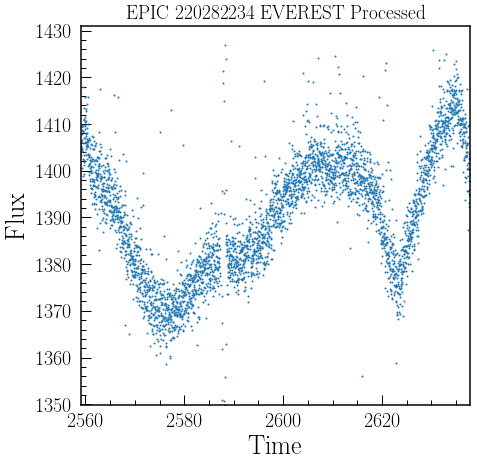

In [12]:
plt.plot(t, flux_cor, marker='.', ls=' ', ms=2)

# some plot formatting
plt.xlabel('Time', fontsize=26)
plt.ylabel('Flux', fontsize=26)
plt.title('EPIC 220282234 EVEREST Processed')
plt.gca().tick_params(axis='both', labelsize=20)

# applying more intelligent plot limits at 2 std
n_std = 2*np.array([-1,1])
# do a little sigma clipping to remove outliers
data_limits = np.mean(flux_cor)+np.std(flux_cor)*n_std
mask = (flux_cor > data_limits[0]) & (flux_cor < data_limits[1])
plot_limits = np.mean(flux_cor[mask])+np.std(flux_cor[mask])*n_std
               
plt.ylim(plot_limits)
plt.xlim(t[[0,-1]]);

We can do this now for all objects by iterating over the list of fits files.

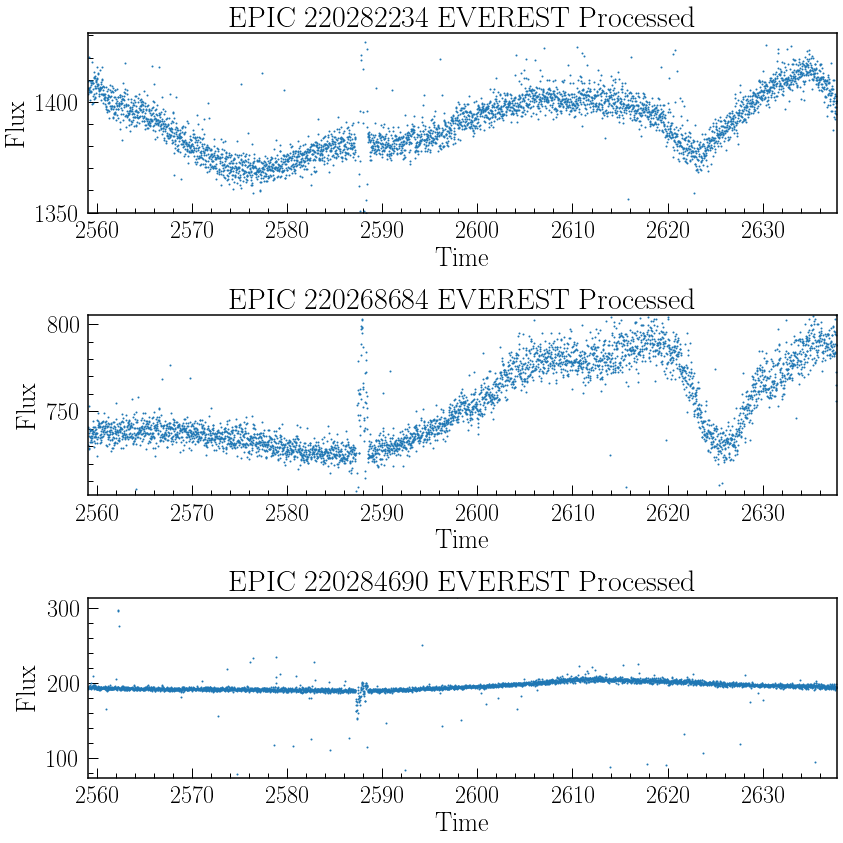

In [13]:
fig, ax = plt.subplots(3,1, figsize=(12,12))

for a, agn in zip(ax, agn_files):
    # retrieve our data for the object
    flux_cor = agn['ARRAYS'].data['FCOR']
    t = agn['ARRAYS'].data['TIME']
    epic = agn['PRIMARY'].header['KEPLERID']
    
    # make a plot of the light curve
    a.plot(t, flux_cor, marker='.', ls=' ', ms=2)

    # some plot formatting
    a.set_xlabel('Time', fontsize=26)
    a.set_ylabel('Flux', fontsize=26)
    a.set_title('EPIC {0} EVEREST Processed'.format(epic), fontsize=30)

    # applying more intelligent plot limits at 2 std
    n_std = 2*np.array([-1,1])
    # do a little sigma clipping to remove outliers
    data_limits = np.mean(flux_cor)+np.std(flux_cor)*n_std
    mask = (flux_cor > data_limits[0]) & (flux_cor < data_limits[1])
    plot_limits = np.mean(flux_cor[mask])+np.std(flux_cor[mask])*n_std

    a.set_ylim(plot_limits)
    a.set_xlim(t[[0,-1]])
    a.tick_params(axis='both', labelsize=24)
    
    agn.close() # good practice not to leave our files open
    
fig.tight_layout()

We can also use the fits downloader to download aribrarily shaped lists of urls in order to quickly download multiple different lights curves quickly.  We'll plot an SAP, SFF, and EVEREST light curve on top of one another to compare them as an example.  (We'll be median normalizing the SAP and SFF light curves to be on the same scale).  Since the formats of all of the light curve files differ, we'll make some convienience functions for extracting the time and flux fields.

The first thing we'll do is set up a function for extracting the light curve information from each file

In [14]:
def get_everest_lc(hdu_list):
    hdu = hdu_list['ARRAYS']
    flux = hdu.data['FCOR']/np.nanmedian(hdu.data['FCOR']) # median normalize
    t = hdu.data['TIME']
    
    return t, flux
    
def get_sff_lc(hdu_list):
    hdu = hdu_list['BESTAPER'] 
    flux = hdu.data['FCOR'] # already normalized
    t = hdu.data['T']
    
    return t, flux
    
    
def get_sap_lc(hdu_list):
    hdu = hdu_list['LIGHTCURVE']
    flux = hdu.data['PDCSAP_FLUX']/np.nanmedian(hdu.data['PDCSAP_FLUX']) # median normalize
    t = hdu.data['TIME']
    
    return t, flux

get_lc = {'everest':get_everest_lc, 'sff':get_sff_lc, 'sap':get_sap_lc}
# We can use this dictionary as a switch

And we'll quickly impliment a basic sigma clipping to make the plots easier to view

In [15]:
def clip(data, n_std=2, n_iter=1):
    '''returns a mask array of the clipped data'''
    mask = np.ones(len(data), dtype=np.bool)
    for _ in xrange(n_iter):
        data_limits = np.nanmean(data[mask])+np.nanstd(data[mask])*n_std*np.array([-1,1])
        mask &= (data > data_limits[0]) & (data < data_limits[1])
    return mask

Now we'll do is set up our lists of urls we want to download

In [16]:
everest_urls = [urls.everest(epicid, campaign) for epicid in agn_epics]
sff_urls = [urls.sff(epicid, campaign) for epicid in agn_epics]
sap_urls = [urls.sap(epicid, campaign) for epicid in agn_epics]

all_urls = zip(everest_urls, sff_urls, sap_urls)

print all_urls

[('https://archive.stsci.edu/hlsps/everest/v2/c08/220200000/82234/hlsp_everest_k2_llc_220282234-c08_kepler_v2.0_lc.fits', 'http://archive.stsci.edu/missions/hlsp/k2sff/c08/220200000/82234/hlsp_k2sff_k2_lightcurve_220282234-c08_kepler_v1_llc.fits', 'https://archive.stsci.edu/missions/k2/lightcurves/c8/220200000/82000/ktwo220282234-c08_llc.fits'), ('https://archive.stsci.edu/hlsps/everest/v2/c08/220200000/68684/hlsp_everest_k2_llc_220268684-c08_kepler_v2.0_lc.fits', 'http://archive.stsci.edu/missions/hlsp/k2sff/c08/220200000/68684/hlsp_k2sff_k2_lightcurve_220268684-c08_kepler_v1_llc.fits', 'https://archive.stsci.edu/missions/k2/lightcurves/c8/220200000/68000/ktwo220268684-c08_llc.fits'), ('https://archive.stsci.edu/hlsps/everest/v2/c08/220200000/84690/hlsp_everest_k2_llc_220284690-c08_kepler_v2.0_lc.fits', 'http://archive.stsci.edu/missions/hlsp/k2sff/c08/220200000/84690/hlsp_k2sff_k2_lightcurve_220284690-c08_kepler_v1_llc.fits', 'https://archive.stsci.edu/missions/k2/lightcurves/c8/2202

Now we can pass this list of lists of urls right into the fits downloader, and iterate over a 2-d list of fits files for plotting

/home/rodot/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  
/home/rodot/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less
  


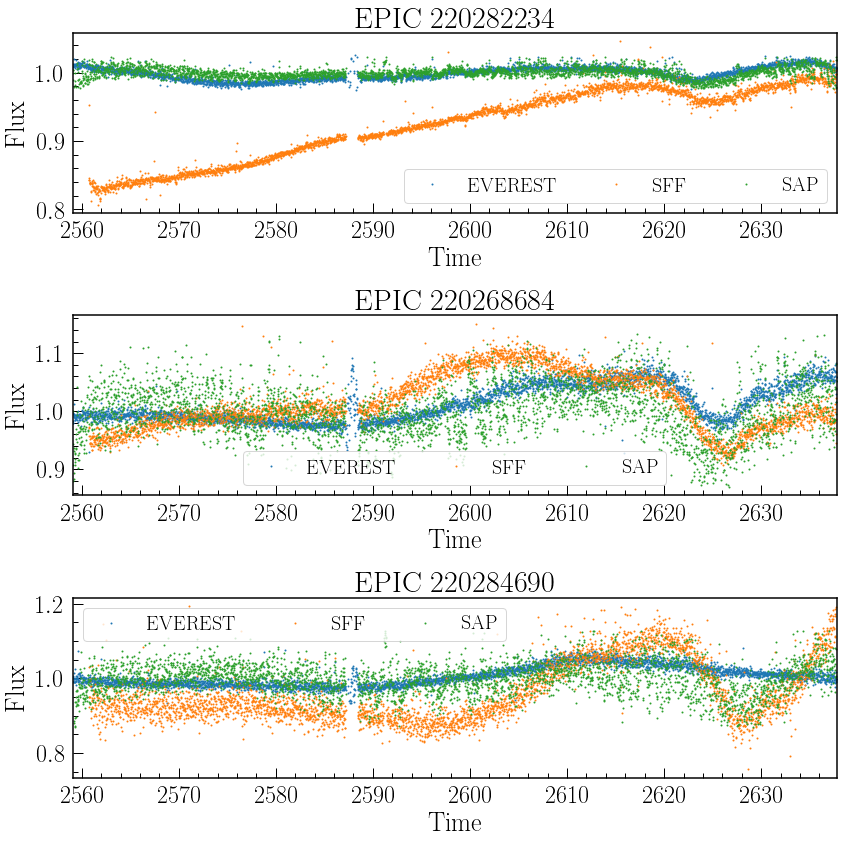

In [17]:
agn_file_set = fits_downloader(all_urls) # no need to make a list this time

fig, ax = plt.subplots(3,1, figsize=(12,12))
n_std = 3

for a, agn_files in izip(ax, agn_file_set):
    # agn_files is another fits_downloader function call to 
    # each nested list of urls
    for hdu_list, processing in izip(agn_files, ('everest','sff','sap')):
        # we zip our hdus with the name of the processing so we know
        # which is which and how to extract the light curve
        t, flux = get_lc[processing](hdu_list) # retrieve the time and flux of the light curve
        epic = hdu_list['PRIMARY'].header['KEPLERID'] # get the epic id from the fits header
        
        mask = clip(flux, n_std, n_iter=5) # cut out outliers for viewing
        a.plot(t[mask], flux[mask], marker='.', ls=' ', ms=2, label=processing.upper())
        
        hdu_list.close() # good practice not to leave our files open

    # some plot formatting
    a.legend(ncol=3, fontsize=20)
    a.set_xlabel('Time', fontsize=26)
    a.set_ylabel('Flux', fontsize=26)
    a.set_title('EPIC {0}'.format(epic), fontsize=30)
    a.tick_params(axis='both', labelsize=24)

    a.set_xlim(t[[0,-1]])


fig.tight_layout()
